# 불균형데이터의 예측모형 개선

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
get_ipython().run_line_magic('matplotlib', 'inline')
plt.rcParams['font.family']='Malgun Gothic' # 한글폰트
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, plot_roc_curve 
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.pipeline import Pipeline, make_pipeline
import scikitplot as skplt
from joblib import dump, load

# 1. 데이터 불러오기

In [4]:
df = pd.read_csv('../../data/creditcard.csv')
df =df.sample(frac=0.1)
df.shape; df.head()

(28481, 31)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
188573,128033.0,1.617384,-1.241592,-1.670955,-0.596069,0.316851,0.994479,-0.148911,0.165043,1.487314,...,0.424888,1.401620,-0.156867,-0.169490,0.095090,1.111358,-0.048152,-0.051999,182.00,0
212078,138702.0,1.979066,-0.152642,-1.025854,0.323935,-0.112247,-0.848707,0.083613,-0.168490,0.279312,...,-0.218627,-0.557859,0.333790,0.017463,-0.361069,0.177105,-0.074034,-0.067612,14.99,0
180970,124771.0,-1.215397,0.571786,2.158492,-0.007907,-0.308239,0.146475,0.336799,0.055504,0.812124,...,-0.233673,-0.230841,-0.324005,0.006968,0.490469,-0.603385,0.159011,0.176524,65.00,0
46686,42887.0,1.048021,0.074661,0.483465,1.350541,-0.211418,0.034510,0.020746,0.101333,-0.007038,...,-0.016377,0.089786,-0.078576,0.237560,0.598897,-0.346034,0.031513,0.013450,39.13,0
54739,46594.0,-0.352781,0.784804,-0.030918,-1.213527,2.459426,3.365564,0.115579,0.937155,-0.521070,...,-0.283099,-0.903428,-0.061688,0.983523,-0.036537,0.086466,0.268068,0.114003,0.89,0


In [7]:
df['Class'].value_counts(normalize=True)

0    0.998631
1    0.001369
Name: Class, dtype: float64

In [8]:
from sklearn.preprocessing import StandardScaler
df['Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1,1))

In [9]:
X = df.drop(['Class', 'Time'], axis=1)
y = df['Class']

Text(0.5, 0, '주성분 개 수')

Text(0, 0.5, '총변동량 누적 설명 비율')

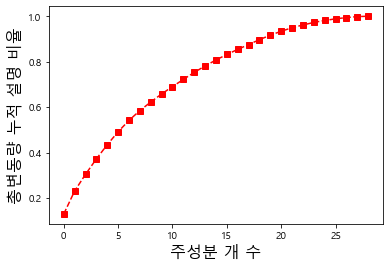

In [10]:
from sklearn.decomposition import PCA
pca = PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_), 'rs--')
plt.xlabel('주성분 개 수', fontsize='16')
plt.ylabel('총변동량 누적 설명 비율', fontsize='16')

In [11]:
pca = PCA(n_components=17)
pca.fit(X)
X_pca = pca.transform(X)

print('총변동량 설명비율 (%) :', np.round(pca.explained_variance_ratio_*100, 2))
np.array(np.round(pca.explained_variance_ratio_*100, 2)).sum()

PCA(n_components=17)

총변동량 설명비율 (%) : [12.97 10.11  7.32  6.8   6.25  5.7   5.    4.33  3.73  3.58  3.23  3.17
  3.11  2.8   2.65  2.41  2.24]


85.39999999999999

In [12]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, 
                                                  stratify= y, random_state=11)

# 2. 손실함수 조정

## 2.1 손실함수 조정전

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5689
           1       1.00      0.25      0.40         8

    accuracy                           1.00      5697
   macro avg       1.00      0.62      0.70      5697
weighted avg       1.00      1.00      1.00      5697



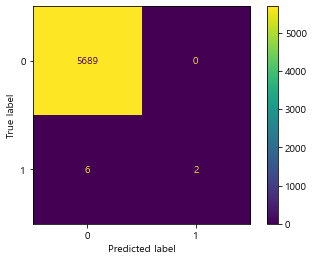

In [14]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state=11)

parameters = {'C': np.linspace(1, 10, 10)}
clf = GridSearchCV(model, parameters, cv=5)

y_predict = clf.fit(X_train, y_train).predict(X_test)

print(classification_report(y_test, y_predict))
plot_confusion_matrix(clf, X_test, y_test)

## lasso

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5689
           1       0.80      0.50      0.62         8

    accuracy                           1.00      5697
   macro avg       0.90      0.75      0.81      5697
weighted avg       1.00      1.00      1.00      5697



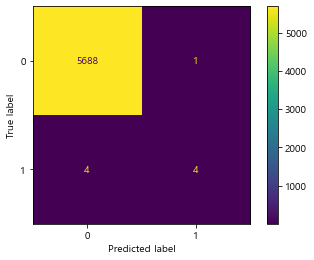

In [15]:
model = LogisticRegression(penalty='l1', solver='saga', random_state=11)
parameters = {'C': np.linspace(1, 10, 10)}
clf = GridSearchCV(model, parameters, cv=5)

y_predict = clf.fit(X_train, y_train).predict(X_test)

print(classification_report(y_test, y_predict))
plot_confusion_matrix(clf, X_test, y_test)

## 2.2 손실함수 조정 후

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      5689
           1       0.14      0.62      0.23         8

    accuracy                           0.99      5697
   macro avg       0.57      0.81      0.61      5697
weighted avg       1.00      0.99      1.00      5697



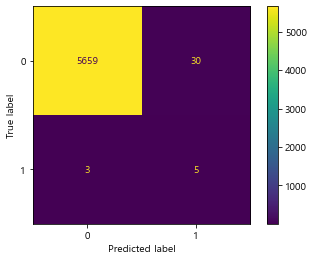

In [25]:
model = LogisticRegression(random_state=11, class_weight='balanced')

parameters = {'C': np.linspace(1, 10, 10)}
clf = GridSearchCV(model, parameters, cv=5)

y_predict = clf.fit(X_train, y_train).predict(X_test)

print(classification_report(y_test, y_predict))
plot_confusion_matrix(clf, X_test, y_test)

0    0.998639
1    0.001361
Name: Class, dtype: float64

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      5689
           1       0.08      0.62      0.14         8

    accuracy                           0.99      5697
   macro avg       0.54      0.81      0.57      5697
weighted avg       1.00      0.99      0.99      5697



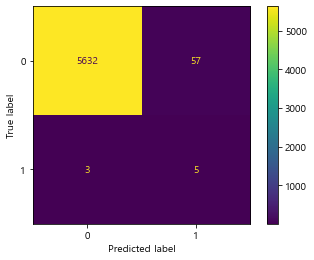

In [26]:
y_train.value_counts(normalize=True)
major = y_train.value_counts(normalize=True)[0]
minor = y_train.value_counts(normalize=True)[1]

model = LogisticRegression(random_state=11, class_weight={0: minor, 1:major})

parameters = {'C': np.linspace(1, 10, 10)}
clf = GridSearchCV(model, parameters, cv=5)

y_predict = clf.fit(X_train, y_train).predict(X_test)

print(classification_report(y_test, y_predict))
plot_confusion_matrix(clf, X_test, y_test)

(array([9377.,  920.,  377.,  229.,  127.,  100.,   81.,   58.,   60.,
          64.]),
 array([3.29553746e-57, 1.00000000e-01, 2.00000000e-01, 3.00000000e-01,
        4.00000000e-01, 5.00000000e-01, 6.00000000e-01, 7.00000000e-01,
        8.00000000e-01, 9.00000000e-01, 1.00000000e+00]),
 <a list of 10 Patch objects>)

(array([  64.,   60.,   58.,   81.,  100.,  127.,  229.,  377.,  920.,
        9377.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

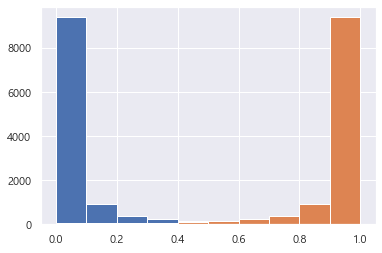

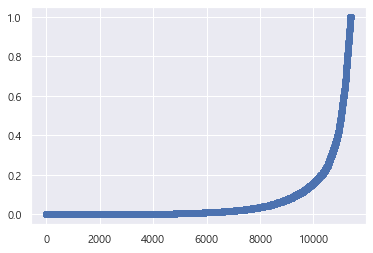

In [106]:
y_proba = clf.predict_proba(X_test)
plt.hist(y_proba[:,1]);
plt.hist(y_proba[:,0]); plt.show()
plt.scatter(np.arange(len(y_test)), np.sort(y_proba[:,1]))

In [104]:
df['Class'].value_counts(normalize=True)

0    0.998455
1    0.001545
Name: Class, dtype: float64

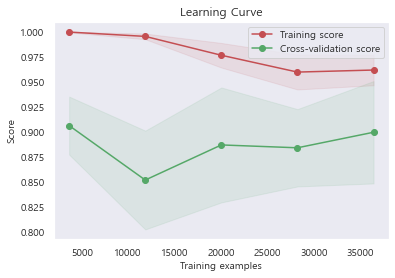

In [105]:
skplt.estimators.plot_learning_curve(clf, X_train, y_train, scoring='recall_macro')

## 1. Sklearn utils
### 손실함수 조정이 가능한 알고리즘

In [107]:
# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier)
# metrics
from sklearn.metrics import roc_curve, precision_recall_curve, auc, precision_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, average_precision_score
from sklearn.metrics import f1_score, recall_score, log_loss, brier_score_loss, matthews_corrcoef
from scipy.stats import ks_2samp

In [108]:
classifiers = {}
classifiers.update({'LGR': LogisticRegression(class_weight='balanced')})
classifiers.update({'SVC': SVC(class_weight='balanced', probability=True)})
classifiers.update({'Decisiontree': DecisionTreeClassifier(class_weight='balanced')})
classifiers.update({'Extratree': ExtraTreesClassifier(class_weight='balanced', n_estimators=250)})
classifiers.update({'Random Forest': RandomForestClassifier(class_weight='balanced', n_estimators=100)})

In [109]:
from tqdm import tqdm_notebook
kf = KFold(n_splits=2)
results = {}
for classifier_label, classifier in tqdm_notebook(classifiers.items()):
    steps = [('classifier', classifier)]
    pipeline = Pipeline(steps = steps)
    param_grid = {}
    
    gs = RandomizedSearchCV(pipeline, param_grid, cv = kf,
                            n_iter = 2,
                            scoring = 'f1_macro')  
    y_pred = gs.fit(X_train, y_train).predict(X_test)
    y_proba = gs.predict_proba(X_test)
    y_score = y_proba[:,1]
    
    result = {'Best Parameters': gs.best_params_,
              'Training recall_macro': gs.best_score_,
              'Test recall_macro': recall_score(y_test, y_pred, average='macro'),
              'AUROC': roc_auc_score(y_test, y_score),
              'Average PR': average_precision_score(y_test, y_score),
              'F1-score': f1_score(y_test, y_pred),
              'Accuracy': cross_val_score(gs, X_train, y_train).mean(),
              'Log_loss': log_loss(y_test, y_proba),
              'Brier_score': brier_score_loss(y_test, y_score),
              'KS_pvalue': ks_2samp(y_test, y_pred)[1]
             }
 
    results.update({classifier_label: result})

In [110]:
pd.DataFrame(results).T.drop(['Best Parameters'], axis=1).sort_values('Log_loss')

,Training recall_macro,Test recall_macro,AUROC,Average PR,F1-score,Accuracy,Log_loss,Brier_score,KS_pvalue
Extratree,0.91245,0.861111,0.999919,0.966414,0.83871,0.908714,0.0013326,0.000317514,1
Random Forest,0.897671,0.861111,0.999883,0.953208,0.83871,0.891001,0.00144976,0.000347187,1
SVC,0.702842,0.693346,0.995184,0.174686,0.28,0.669425,0.00626282,0.00157338,1
Decisiontree,0.835327,0.833158,0.833158,0.500527,0.705882,0.840477,0.0303158,0.000877732,1
LGR,0.539118,0.984835,0.999937,0.972573,0.0944882,0.533112,0.0974472,0.0249417,5.68522e-05


# 2. SMOTE

In [131]:
from imblearn.over_sampling import SMOTE # pip install imbalearn
sm = SMOTE(sampling_strategy = 0.8, random_state=10)
X_train_smote, y_train_smote = sm.fit_sample(X_train, y_train)
X_train.shape, X_train_smote.shape

((45568, 17), (81889, 17))

In [147]:
sm = SMOTE(random_state=2)
X_train_smote, y_train_smote = sm.fit_sample(X_train, y_train)
X_train.shape, X_train_smote.shape
X_train, y_train = X_train_smote, y_train_smote
X_train.shape, y_train.shape

((90988, 17), (90988, 17))

((90988, 17), (90988,))

## 2.1 로짓 회귀분석 모형

In [148]:
model = LogisticRegression(random_state=11)
parameters = {'C': np.linspace(1, 10, 10)}
clf = GridSearchCV(model, parameters, cv=5)

In [149]:
clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=11),
             param_grid={'C': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])})

In [150]:
clf.best_params_

{'C': 3.0}

In [151]:
lr1 = LogisticRegression(C=3, penalty='l1', solver='saga', verbose=5)
lr1.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 94 epochs took 3 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.8s finished


LogisticRegression(C=3, penalty='l1', solver='saga', verbose=5)

In [152]:
y_predict = lr1.predict(X_test)

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     11375
           1       0.04      0.78      0.07        18

    accuracy                           0.97     11393
   macro avg       0.52      0.87      0.53     11393
weighted avg       1.00      0.97      0.98     11393



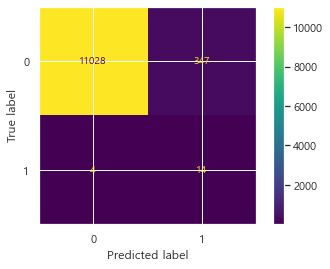

In [153]:
print(classification_report(y_test, y_predict))
plot_confusion_matrix(lr1, X_test, y_test)

## 2.2 랜덤포레스트 모형

In [136]:
model = RandomForestClassifier(n_estimators=300)
y_predict = model.fit(X_train, y_train).predict(X_test)
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11375
           1       0.71      0.56      0.63        18

    accuracy                           1.00     11393
   macro avg       0.86      0.78      0.81     11393
weighted avg       1.00      1.00      1.00     11393



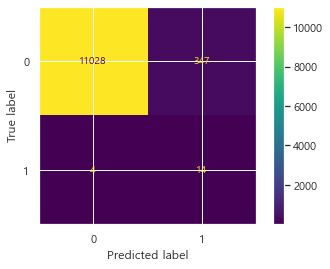

In [137]:
plot_confusion_matrix(clf, X_test, y_test)

In [138]:
y_train.value_counts()

1    45494
0    45494
Name: Class, dtype: int64

# END